In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import os
import cv2
import PIL
import torchvision
import torchvision.transforms as transforms
import datetime
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
from torchvision.utils import make_grid, save_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet50 = models.resnet50(pretrained = True).to(device) # 모델로드
resnet50.eval() # 사전학습 했기에 고정하는 코드

D:\anaconda\envs\main\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\anaconda\envs\main\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\dext/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

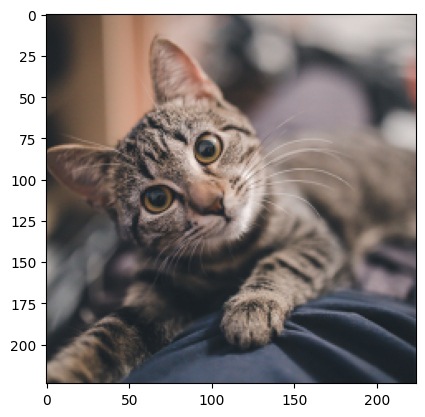

In [56]:
image = np.array(cv2.imread(r"C:\Users\dext\Desktop\ed\cat.jpg"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
plt.imshow(image)

In [57]:
def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)
    
    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)
    
    def undo(self, tensor):
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [58]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 사전학습데이터 표준화 값 own data 사용시 필요 없음
torch_img = torch.from_numpy(np.asarray(image)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda() # 토치 텐서로 변경
torch_img = F.interpolate(torch_img, size=(224, 224), mode='bilinear', align_corners=False) # (1, 3, 224, 224) # 데이터 리사이즈
normed_torch_img = normalizer(torch_img) # (1, 3, 224, 224) # 사전학습데이터 표준화 값 own data 사용시 필요 없음

In [59]:
# final conv layer name 
finalconv_name = 'layer4' # 가져올 레이어

# activations
feature_blobs = []

# gradients
backward_feature = []

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data)
    

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])
    

resnet50._modules.get(finalconv_name).register_forward_hook(hook_feature)
resnet50._modules.get(finalconv_name).register_backward_hook(backward_hook)

In [60]:
# get the softmax weight
params = list(resnet50.parameters())
weight_softmax = np.squeeze(params[-2].cpu().detach().numpy()) # [1000, 512]

# Prediction
logit = resnet50(normed_torch_img) # 예측

In [61]:
prediction = torch.max(resnet50(normed_torch_img).data,1)[1]
print("정답 라벨은", prediction)

정답 라벨은 tensor([281], device='cuda:0')


In [62]:
# ============================= #
# ==== Grad-CAM main lines ==== #
# ============================= #
score = logit[:, prediction.item()].squeeze() # 예측값 y^c
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행

In [63]:
activations = feature_blobs[0].to(device) # (1, 512, 7, 7), forward activations
gradients = backward_feature[0] # (1, 512, 7, 7), backward gradients
b, k, u, v = gradients.size()

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

In [64]:
grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(224, 224), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 224, 224), min-max scaling

In [65]:
# grad_cam_map.squeeze() : (224, 224)
grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy
grad_heatmap = np.float32(grad_heatmap) / 255
grad_heatmap = cv2.cvtColor(grad_heatmap, cv2.COLOR_BGR2RGB)

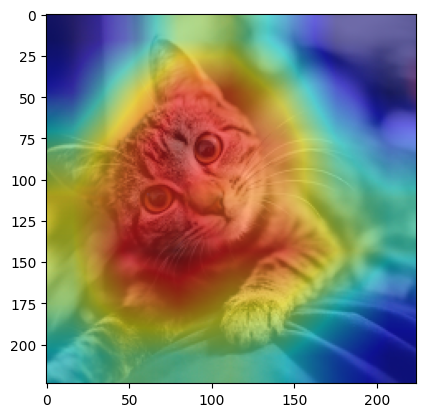

In [66]:
plt.imshow(image)
plt.imshow(grad_heatmap, alpha=0.5)

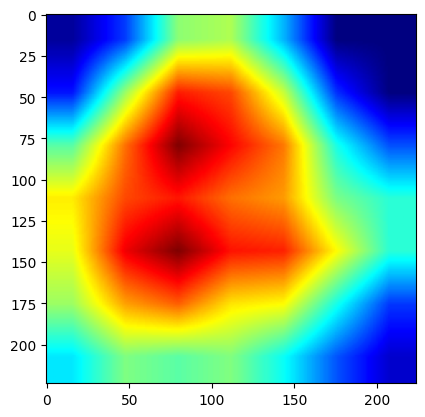

In [69]:
plt.imshow(grad_heatmap)